In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
path = Path('/home/jupyter/data/carvana')
path.ls()

[PosixPath('/home/jupyter/data/carvana/train_masks.zip'),
 PosixPath('/home/jupyter/data/carvana/carvana-image-masking-challenge.zip'),
 PosixPath('/home/jupyter/data/carvana/metadata.csv'),
 PosixPath('/home/jupyter/data/carvana/test.zip'),
 PosixPath('/home/jupyter/data/carvana/labels'),
 PosixPath('/home/jupyter/data/carvana/train.zip'),
 PosixPath('/home/jupyter/data/carvana/29bb3ece3180_11.jpg'),
 PosixPath('/home/jupyter/data/carvana/test'),
 PosixPath('/home/jupyter/data/carvana/train_masks.csv'),
 PosixPath('/home/jupyter/data/carvana/train'),
 PosixPath('/home/jupyter/data/carvana/sample_submission.csv'),
 PosixPath('/home/jupyter/data/carvana/train_hq.zip'),
 PosixPath('/home/jupyter/data/carvana/test_hq.zip')]

In [4]:
subfolder = 'original'
path_train = path/'train'
path_img = path/f'train/{subfolder}'
path_lbl = path/f'labels/{subfolder}'

In [5]:
img_f = path_img.ls()[0]

(torch.Size([3, 1280, 1918]), None)

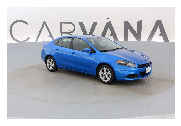

In [6]:
img = open_image(img_f)
img.shape, img.show()

In [7]:
get_y_fn = lambda x: path_lbl/f'{x.stem}.png'

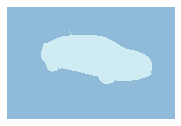

In [8]:
mask = open_mask(get_y_fn(img_f))
mask.show()

In [9]:
src_size = np.array(img.shape[1:]); src_size

array([1280, 1918])

In [10]:
size = src_size // 2
bs = 3
size

array([640, 959])

In [11]:
src = (SegmentationItemList.from_folder(path_train)
       .filter_by_folder(subfolder)
       .split_by_rand_pct(0.2, seed=42)
       .label_from_func(get_y_fn, classes=[0, 'car']))

In [12]:
data = (src
        .transform(get_transforms(), tfm_y=True, size=size)
        .databunch(bs=bs, num_workers=16)
        .normalize(imagenet_stats))

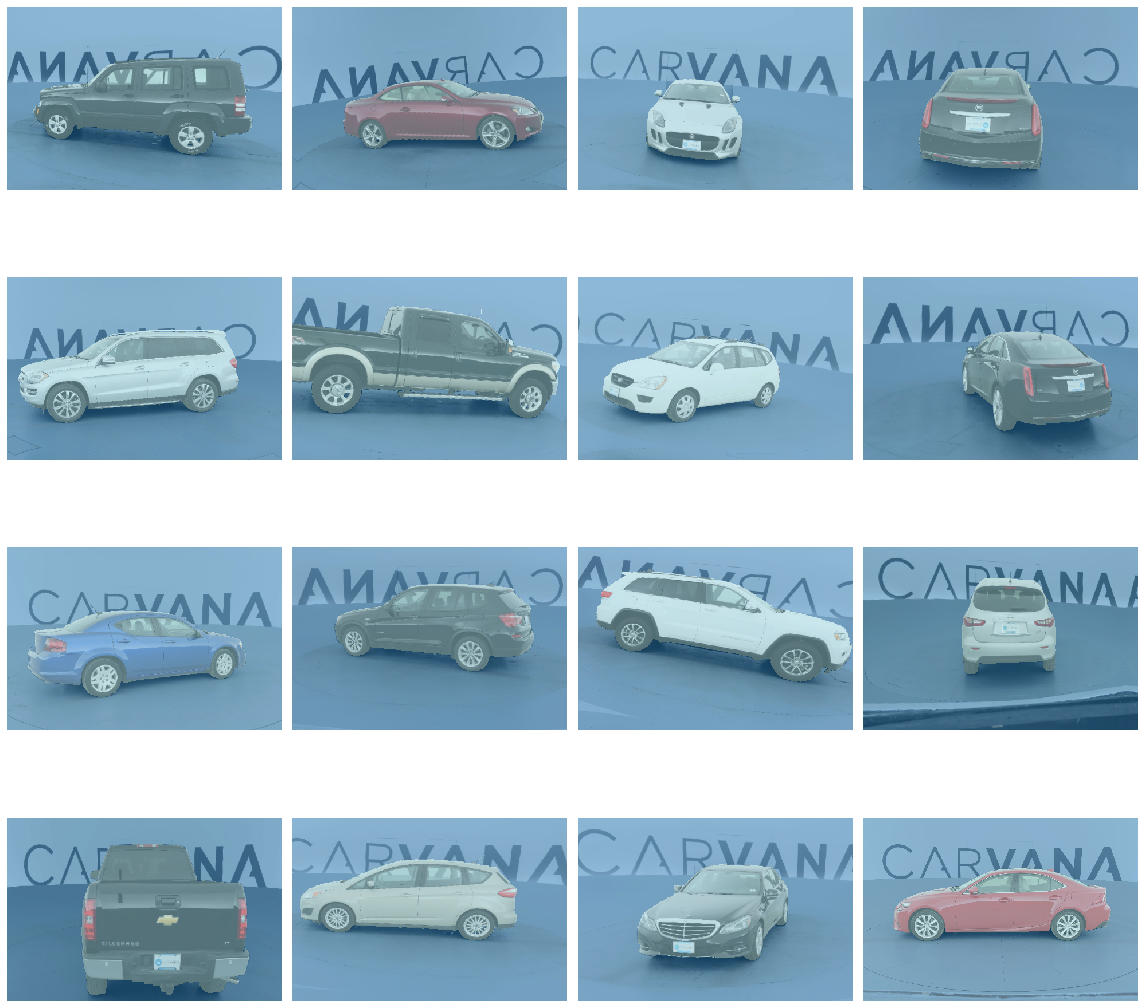

In [13]:
data.show_batch()

In [13]:
learn = None
gc.collect()

4017

In [13]:
learn = unet_learner(data=data, arch=models.resnet34, metrics=[dice])

In [15]:
learn.load('stage-2-2')

Learner(data=ImageDataBunch;

Train: LabelList (4071 items)
x: SegmentationItemList
Image (3, 640, 959),Image (3, 640, 959),Image (3, 640, 959),Image (3, 640, 959),Image (3, 640, 959)
y: SegmentationLabelList
ImageSegment (1, 640, 959),ImageSegment (1, 640, 959),ImageSegment (1, 640, 959),ImageSegment (1, 640, 959),ImageSegment (1, 640, 959)
Path: /home/jupyter/data/carvana/train;

Valid: LabelList (1017 items)
x: SegmentationItemList
Image (3, 640, 959),Image (3, 640, 959),Image (3, 640, 959),Image (3, 640, 959),Image (3, 640, 959)
y: SegmentationLabelList
ImageSegment (1, 640, 959),ImageSegment (1, 640, 959),ImageSegment (1, 640, 959),ImageSegment (1, 640, 959),ImageSegment (1, 640, 959)
Path: /home/jupyter/data/carvana/train;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [16]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


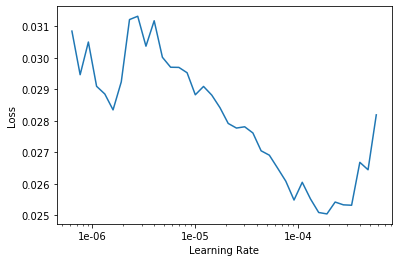

In [17]:
learn.lr_find()
learn.recorder.plot()

In [18]:
lr = 2e-5
learn.fit_one_cycle(2, lr)

epoch,train_loss,valid_loss,dice,time
0,0.009090,0.007310,0.993283,18:55
1,0.008950,0.006570,0.993876,18:56


In [19]:
learn.save('stage-1-2')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


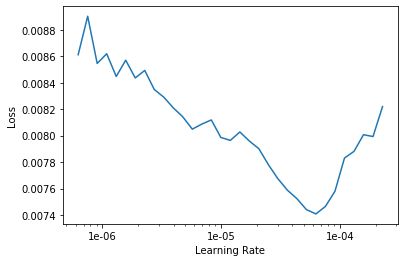

In [20]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [21]:
learn.fit_one_cycle(1, slice(1e-6, lr/5))

epoch,train_loss,valid_loss,dice,time
0,0.007016,0.006421,0.993975,19:41


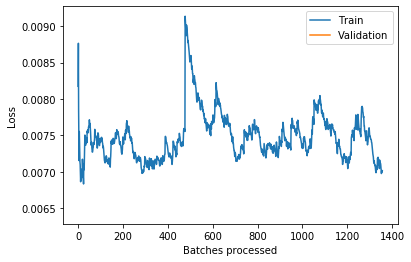

In [22]:
learn.recorder.plot_losses()

In [23]:
mname = 'stage-2-2'

In [24]:
learn.save(mname)

In [ ]:
learn.load(mname)

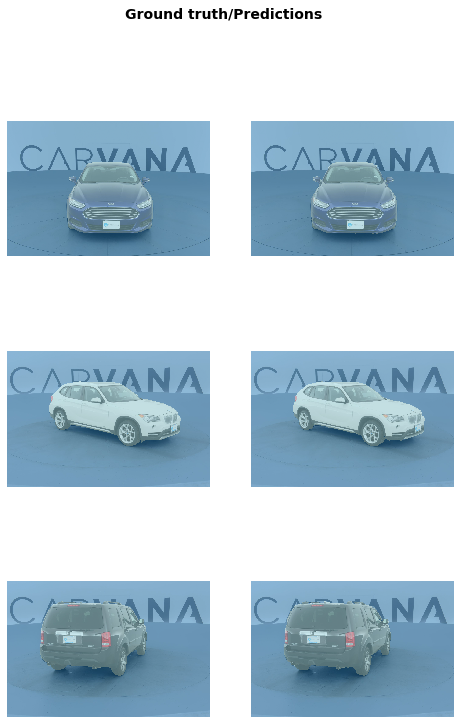

In [26]:
learn.show_results()

In [16]:
test_data

SegmentationItemList (100064 items)
Image (3, 1280, 1918),Image (3, 1280, 1918),Image (3, 1280, 1918),Image (3, 1280, 1918),Image (3, 1280, 1918)
Path: /home/jupyter/data/carvana/test/test

In [23]:
test_data = SegmentationItemList.from_folder(path/'test/test')
data_test = (src
        .transform(get_transforms(), tfm_y=False, size=size)
        .add_test(test_data)
        .databunch(bs=10, num_workers=16)
        .normalize(imagenet_stats))

In [24]:
learn.data = data_test
gc.collect()

20

In [ ]:
test_preds=learn.get_preds(DatasetType.Test)
# test_df["rle_mask"]=np.exp(test_preds[0].data).numpy().T[0]
# test_df[["Id","Sales"]]=test_df[["Id","Sales"]].astype("int")
# test_df[["Id","Sales"]].to_csv(path/"rossmann_submission.csv",index=False)

In [20]:
learn.path

PosixPath('/home/jupyter/data/carvana/train')

In [31]:
learn.model[:-4]

ModuleList(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [32]:
cut = learn.model[:-4]
save_dir = path/'cut_models'
save_dir.mkdir(exist_ok=True)
torch.save(cut.state_dict(), save_dir/'cut4.pth')

In [24]:
cut = torch.load(path/'cut_models/cut1.pth')
learn.model[:-1].load_state_dict(cut)

<All keys matched successfully>